<a href="https://colab.research.google.com/github/Anonymous1846/ALL-Detection-Using-CNN/blob/master/ALL_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing All The Necessary Dependancies.**

In [3]:
'''
Importing all the necessary dependencies for the Binary Classification model !
In the end we have verified the keras installtion, by printing out the keras version.
keras/tensorflow - for developing and training the DL(CNN) model !
os,random - for selection of the images from the directory !
Each Model is stored in its respective directory along with its history file !
'''
from keras.layers import MaxPooling2D,Conv2D,Dropout,Dense,Flatten,BatchNormalization,MaxPool2D #layers
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing.image import ImageDataGenerator #for augmentation
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.callbacks import ModelCheckpoint # for checkpoint calculation and callback
from keras.applications import InceptionV3
from keras.preprocessing import image
from keras.applications import VGG19
from keras.applications import VGG16
from keras.models import Sequential
import matplotlib.pyplot as plt # for plotting 
import tensorflow as tf
from cv2 import imread
import numpy as np
import pickle #for pickling the history dictionary !
import keras
import os 
 
# reading the image via  a path 
#causes an error if the keras installtion didn't went well !
print(keras.__version__)

2.4.3


# **Loading the Dataset(i.e Cancer cell images).**

In [3]:
'''
This is an optional block of code which can be executed if the 
google drive needs to be mounted on different account
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
'''
The Images required for the training, validation, and testing is found in the /Architecture Datasets directory !
Architecture Datasets 
|
|
|
 ---- Training(80 %)
      |
      |
      ----Normal 
      |
      ----Blasts
|
|
---- Validation (10 %)
      |
      |
      ----Normal 
      |
      ----Blasts
|
|
---- Testing (10 %)
      |
      |
      ----Normal 
      |
      ----Blasts

      The images/dataset is divided into 80% training, 10% testing and 10% validation
'''
training_data_path="/content/drive/MyDrive/Architecture Datasets/Training"
validation_data_path="/content/drive/MyDrive/Architecture Datasets/Validation"
testing_data_path="/content/drive/MyDrive/Architecture Datasets/Testing"

print(f'The Training Images Path :{training_data_path}')
print(f'The Validation Images Path :{validation_data_path}')



The Training Images Path :/content/drive/MyDrive/Architecture Datasets/Training
The Validation Images Path :/content/drive/MyDrive/Architecture Datasets/Validation


# **Image Preprocessing Custom**

In [59]:
'''
ALL-IDB1 and ALL IDB2 both contains roughly 334 images, but after spiltting of the images,
the size becomes significantly low, and this leads significant amount of overfitting.
So, inorder to solve the problem of overfitting, we have to apply data augmentation 
to increase the number of images, from the previous existing images !
'''

training_images_preprocessed=ImageDataGenerator(rescale=1./255,
                                                rotation_range=40,
                                                horizontal_flip=True,
                                                fill_mode='nearest')

validate_images_preprocessed = ImageDataGenerator(rescale=1./255,rotation_range=40)


# **Preprocessing Via Pre-Process Function**

In [22]:
'''
Important Note : If you're running the custom model please run the above function only.
This block is only applicable to Transfer Learning !
'''

training_images_preprocessed=ImageDataGenerator(preprocessing_function=preprocess_input)

validate_images_preprocessed = ImageDataGenerator(preprocessing_function=preprocess_input)

# **Applying the Image Augmentation to Training and Validation Set !**

In [66]:
'''
The function augments the data, according to the processing mode.
The processing mode has defined earlier seperately for training and validation set !

params: training/validation directory and the processing mode(different for training and validation dataset)

return: augmented data 
'''

def apply_augmentation(data_directory,processing_mode,flag):
  model_dict = {'AlexNet':(227,227),'Binary':(300,300),'VGG':(224,244)}
  data_gen = validate_images_preprocessed.flow_from_directory(
  data_directory,                               # the directory as provided to the function as an arguement !
  target_size = model_dict[flag],               # 300x 300 pixels for custom,224 for VGG, and 227 for AlexNet 
  batch_size = 128,                             # Number of Images Excepted at Iteration !
  class_mode='binary')
  return data_gen


architecture='Binary'

training_images_datagen = apply_augmentation(training_data_path,training_images_preprocessed,architecture)# change it to false when we have to use binary_classification_0

valid_images_datagen = apply_augmentation(validation_data_path,validate_images_preprocessed,architecture)

test_images_datagen = apply_augmentation(testing_data_path,validate_images_preprocessed,architecture)

print(training_images_datagen.class_indices) # class indices refer to the numerical equivalent whether they are cancerours or not !


Found 268 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
{'Blasts': 0, 'Normal': 1}


#**Using the mean pixel we have calculated the number of features !**

In [10]:
sample_image0=imread('/content/drive/MyDrive/Architecture Datasets/Training/Blasts/Im031_1.jpg')
print("The diemensions of the cancer cell: {}".format(sample_image0.shape))
feature_matrix0 = np.zeros((sample_image0.shape[0], sample_image0.shape[1])) # for cancer cell

'''
The function will calculate the mean pixels values which are essential in understanding the number of possible 
values/ features in the image !

params: fetaure matrix and image

return: None
'''
def show_features(feature_matrix,img):
  for i in range(1,img.shape[0]):
    for j in range(1,img.shape[1]):
        feature_matrix[i][j] = ((int(img[i,j,0]) + int(img[i,j,1]) + int(img[i,j,2]))/3) # mean for three channels !

  features = np.reshape(feature_matrix, (img.shape[0]*img.shape[1])) 
  print("The mean pixels values for the cancer cells: {}".format(features.shape[0]))

show_features(feature_matrix0,sample_image0) # for cancer cell 


The diemensions of the cancer cell: (1368, 1712, 3)
The mean pixels values for the cancer cells: 2342016


# **Representation of Images.**

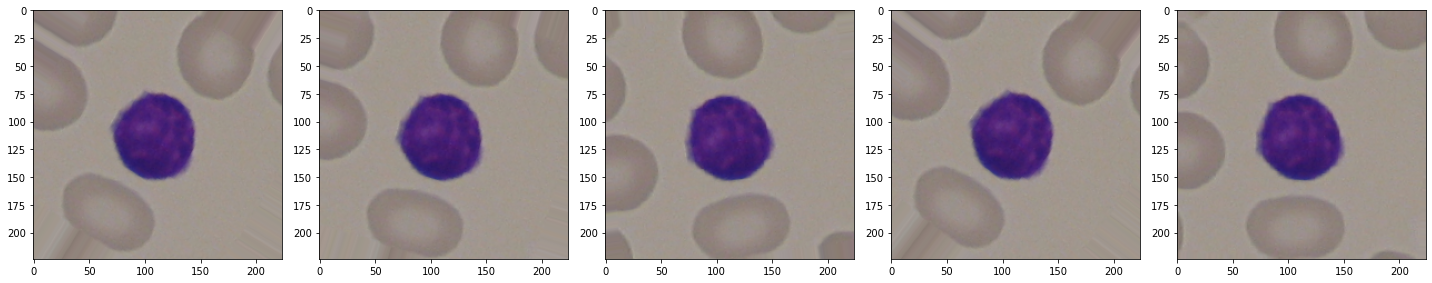

In [ ]:
'''
The function is used to plot the augmented figures of the images, for visual demonstartion !

params: image object
return: 5 plotted images
'''
def plot(image):
  fig,axes=plt.subplots(1,5,figsize=(20,20))# 20 x 20 images 
  axes=axes.flatten()
  for imag,axis in zip(image,axes):
    #the zip function takes two params(iteratables and combines then to form a list of tuples !)
    axis.imshow(imag)
  plt.tight_layout()
  plt.show()

training_images_datagen.class_indices
sample_images=[training_images_datagen[0][0][0] for i in range(5)]
plot(sample_images)

# **Binary CNN Classifier 0!**

In [68]:
'''
The CNN model is used to predict whether the given data image is cancerous or not,
it contains 5 convolution and corresponding number of maxpooling layers.
RelU function is added to each layer so that it can introduce non-linearity and 
avoid the negative values !
'''
the_binary_cnn_model0=Sequential([
                                    Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)), # relu function is used to negate the negative values from the models, replace them with zeros !
                                    MaxPooling2D(2, 2),
                                    Conv2D(32, (3,3), activation='relu'),# The second convolution
                                    MaxPooling2D(2,2),                                    
                                    Conv2D(64, (3,3), activation='relu'),# The third convolution
                                    MaxPooling2D(2,2),                                   
                                    Conv2D(64, (3,3), activation='relu'), # The fourth convolution
                                    MaxPooling2D(2,2),                                   
                                    Conv2D(64, (3,3), activation='relu'), # The fifth convolution
                                    MaxPooling2D(2,2),                                   
                                    
                                    Flatten(),                            # Flatten the  results to feed into a DNN                                    
                                    Dense(512, activation='relu'),        # 512 neuron hidden layer
                                    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('normal') and 0 for the other 'cancer'
                                    Dense(1, activation='sigmoid') # the output will be the range of -1 and 1(graph will be S shaped !)
                                        ])

the_binary_cnn_model0.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 33, 33, 64)       

# **Binary Classifier Based On AlexNet Architecture**

In [ ]:
'''
Implementation of the AlexNet architecture, which is an common architecture of the CNN model
The AlexNet Alrchitecture has been modified since, the original one is capable of classifiying
upto 1000 tensors, and requires more computational power !
'''
alexnet_model =Sequential([
                    Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)),
                    MaxPooling2D((3, 3)),
                    Conv2D(64, (5, 5), activation='relu'),
                    MaxPooling2D((3, 3)),
                    Conv2D(128, (3, 3), activation='relu'),
                    Conv2D(256, (3, 3), activation='relu'),
                    Conv2D(512, (3, 3), activation='relu'),
                    MaxPooling2D((3, 3)),
                    Flatten(),
                    Dense(4096, activation='relu'),# two sense layers with 4096 nuerons each 
                    Dropout(0.4),
                    Dense(4096, activation='relu'),
                    Dense(1, activation='sigmoid')# sigmoid used to binary other wise softmax will be used for probabilitic classification!
                    #Padding calculation = input_size + 2 * padding_size-(filter_size-1)
])
print(alexnet_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 225, 225, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 19, 19, 256)       295168    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 17, 17, 512)      

# **Binary Classifier Based On VGG 19**

In [38]:
vgg19_initial = VGG19(
                      include_top = False,
                      weights = 'imagenet',
                      input_shape = (224,224,3),
                      )
vgg19_model = Sequential([
              vgg19_initial,
              Flatten(),
              Dropout(0.5),
              Dense(256,activation='relu'),
              Dense(1,activation='sigmoid')
                        ])
vgg19_initial.trainable = False

vgg19_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 26,447,425
Trainable params: 6,423,041
Non-trainable params: 20,024,384
_________________________________________________________________


# **Binary Classifier Based On VGG Net 16**

# **Compile the model**

In [69]:
'''
Compiling the model using the loss function binary crossentropy and RMSProp !

return : None

params : model object 
'''
def compile_model(model):
  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(lr=0.001),
                metrics=['accuracy'])
compile_model(the_binary_cnn_model0)


# **Validation and CallBack Lists**

In [70]:
'''
The below callback list is used to moniter the validation accuracy, and the save the best version of the
CNN model. The paths has been specified for later use !
'''

model_path    = '/content/drive/MyDrive/Binary Classifier Models /Binary Classifier Model 0/Binary_Classifier_Model.h5'
alexnet_path  = '/content/drive/MyDrive/Binary Classifier Models /AlexNet Based Model/AlexNet_Classifier_Model.h5'
vgg19_path    = '/content/drive/MyDrive/Binary Classifier Models /VGG 19/VGG_19.h5' 

callback_checkpoint=ModelCheckpoint(model_path,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callback_checkpoint_list=[callback_checkpoint]

# **Training the datset based on given model !**

In [2]:
'''
The below function takes in an arguement, which is the model to be trained and it trains the dataset with the specified model
epochs:100

Params: model object

Return the trained object
'''

def train_the_model(model):
  the_final_train = model.fit(
                      training_images_datagen,
                      callbacks=callback_checkpoint_list,
                      batch_size=128,
                      validation_data=valid_images_datagen,
                      steps_per_epoch=3, #the steps per epoch is set to 2, but cannot be set to more than 3(because of error !) 
                      epochs=100,
                      verbose=2,
                    )
  return the_final_train


trained_model=train_the_model(the_binary_cnn_model0)

NameError: ignored

# **Saving History Pickle File !**

In [43]:
binary_class_pickle  = '/content/drive/MyDrive/Binary Classifier Models /Binary Classifier 0/Binary Classifier.pickle'
alexnet_pickle       = '/content/drive/MyDrive/Binary Classifier Models /AlexNet Classifier/AlexNet.pickle' 
vgg19_pickle         = '/content/drive/MyDrive/Binary Classifier Models /VGG 19/VGG19.pickle'

In [44]:
'''
The model cannot path cannot be directly used to retrieve the history thats
why we are saving the respective model history to a pickle file 

return : None

params : model_history and path of pickle file 
'''

def save_file(pickle_dir,model_history):
  with open(pickle_dir,'wb') as binary_pickle:
    binary_pickle.write(pickle.dumps(model_history)) #dumping to pickle before writing to pickle file !
    print(f'History Saved to {pickle_dir}')

save_file(vgg19_pickle,trained_model.history) #the path of the model history pickle and the current model history !

History Saved to /content/drive/MyDrive/Binary Classifier Models /VGG 19/VGG19.pickle


# **Accuracy and Loss Graph !**

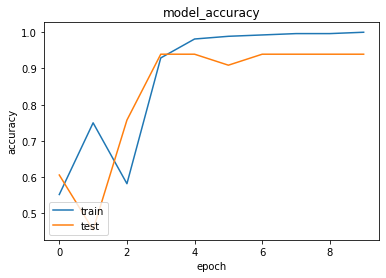

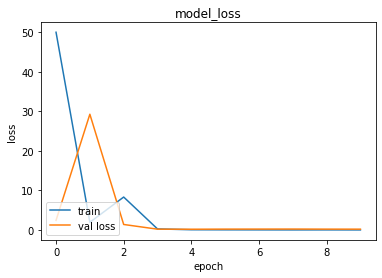

100.0


In [45]:
with open(vgg19_pickle,'rb') as model_history: #opening the pickle file which contains the dictionary !
  model_history_dict=model_history.read()
'''
The accuracy and the losses at each iteration/epoch is evaluated in the graph below
matplotlib is used for plotting.

return:None

params:model history path
'''
def plot_metrics(model):
  model=pickle.loads(model)
  plt.plot(model['accuracy'])
  plt.plot(model['val_accuracy'])
  plt.title('model_accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'],loc='lower left')
  plt.show()

  plt.plot(model['loss'])
  plt.plot(model['val_loss'])
  plt.title('model_loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','val loss'],loc='lower left')
  plt.show()


plot_metrics(model_history_dict)
print(pickle.loads(model_history_dict)['accuracy'][-1]*100)

In [ ]:
print(type(training_images_datagen))

<class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>


#**Testing for Cancer vs Normal**

In [56]:
'''
The final module of the system which basically predicts whether given cell is a blast or normal cell,
based on the image and the prediction model file !

return: Blast or Not 

params: path to the model and the path to the image !
'''

def check_for_cancer(model,image_path):
  model = keras.models.load_model(model) #loading the model.h5 from the drive !
  img = image.load_img(image_path, target_size=(224,224)) # loading the image in 300x300 diemensions(227x227x3 for AlexNet)
  img = image.img_to_array(img)
  
  img = np.expand_dims(img, axis=0)#expanding along one axis 
  result_vector = model.predict(img).round(3) #the array is passed to the model for prediction
  print(result_vector)
  if result_vector == 0 :
      return "Cancer Cell"
  else:
      return "Normal Cell"

print('Prediction Based on the Binary Classifier 0 Classifier !')
print(check_for_cancer('/content/drive/MyDrive/Binary Classifier Models /VGG 19/VGG_19.h5','/content/drive/MyDrive/Architecture Datasets/Testing/Blasts/Im007_1.jpg'))
print(check_for_cancer('/content/drive/MyDrive/Binary Classifier Models /VGG 19/VGG_19.h5','/content/drive/MyDrive/Architecture Datasets/Testing/Normal/Im073_0.jpg'))
# print('Prediction Based on the AlexNet Classifier !')
# print(check_for_cancer('/content/drive/MyDrive/Binary Classifier Models /AlexNet Based Model/AlexNet_Classifier_Model.h5','/content/drive/MyDrive/Architecture Datasets/Validation/Blasts/Im010_1.tif'))
# print(check_for_cancer('/content/drive/MyDrive/Binary Classifier Models /AlexNet Based Model/AlexNet_Classifier_Model.h5','/content/drive/MyDrive/Architecture Datasets/Testing/Normal/Im065_0.jpg'))



Prediction Based on the Binary Classifier 0 Classifier !
1/1 [==============================] - 3s 3s/step - loss: 0.0887 - accuracy: 0.9697
[[0.]]
Cancer Cell
1/1 [==============================] - 3s 3s/step - loss: 0.0887 - accuracy: 0.9697
[[0.333]]
Normal Cell


# **Metrics Analysis**